In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Show the first row of the table Station
session.query(station).first().__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25e1e327ee0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [11]:
# Show the first row of Table Measurement
session.query(measure).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25e1e34db20>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0}

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
last_date = session.query(measure.date).order_by(measure.date.desc()).first()
last_date

('2017-08-23',)

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdate = dt.datetime.strptime(last_date.date, '%Y-%m-%d').date()
lastdate

datetime.date(2017, 8, 23)

In [27]:
# Calculate the date one year from the last date in data set.
year_ago =  lastdate - dt.timedelta(days = 365)
year_ago

datetime.date(2016, 8, 23)

In [60]:
# Perform a query to retrieve the data and precipitation scores
latest = session.query(measure.station, measure.date, measure.prcp).filter(measure.date >= year_ago).all()

In [61]:
# Save the query results as a Pandas DataFrame and set the index to the date column
lastyr_df = pd.DataFrame(latest, columns=['Station','Date', 'Precipitation'])
lastyr_df.sort_values(by = ["Date"], inplace = True)
lastyr_df

,Station,Date,Precipitation
0,USC00519397,2016-08-23,0.00
1009,USC00517948,2016-08-23,NaN
1529,USC00519281,2016-08-23,1.79
704,USC00514830,2016-08-23,0.05
361,USC00513117,2016-08-23,0.15
...,...,...,...
1527,USC00519523,2017-08-22,0.00
1008,USC00514830,2017-08-23,0.00
360,USC00519397,2017-08-23,0.00
1528,USC00519523,2017-08-23,0.08


Text(0.5, 1.0, 'Precipitation from 2016-08-23 to 2017-08-23')

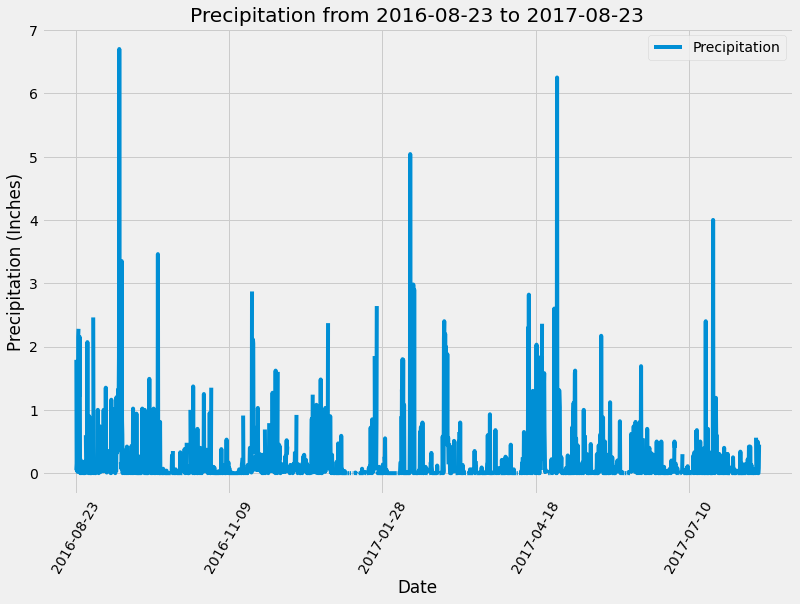

In [64]:
# Use Pandas Plotting with Matplotlib to plot the data
lastyr_df.plot(x='Date', y='Precipitation', rot=45, figsize=(12,8))
plt.xticks(rotation='60')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title(f"Precipitation from {year_ago} to {lastdate}")

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyr_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [71]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
total_stations

9

In [76]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
top_stations = session.query(measure.station, func.count(measure.id)).group_by(measure.station).order_by(func.count(measure.id).desc()).all()
top_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
topstations_df = pd.DataFrame(top_stations, columns=['Station','Count'])
most_active = topstations_df.iloc[0].Station
most_active

'USC00519281'

In [99]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_temp_min, active_temp_max, active_temp_mean = session.query(func.min(measure.tobs),func.max(measure.tobs),func.avg(measure.tobs)).filter(measure.station == most_active).\
    order_by(measure.date).first()
print(f"The most active station id is {most_active}.")
print(f"The lowest temperature is {active_temp_min} degrees Fahrenheit.")
print(f"The highest temperature is {active_temp_max} degrees Fahrenheit.")
print(f"The average temperature is {round(active_temp_mean,2)} degrees Fahrenheit.")


The most active station id is USC00519281.
The lowest temperature is 54.0 degrees Fahrenheit.
The highest temperature is 85.0 degrees Fahrenheit.
The average temperature is 71.66 degrees Fahrenheit.


Text(0.5, 1.0, 'USC00519281 \n Temp Observation Data \n from 2016-08-23 to 2017-08-23')

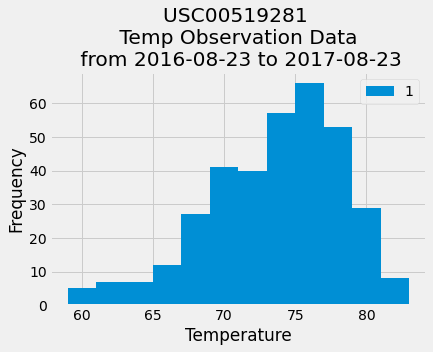

In [138]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activelastyr = session.query(measure.date, measure.tobs).filter_by(station = f'{most_active}').\
    filter(measure.date >= year_ago).all()

# Create dataframe for plotting histogram
activeyrdf = pd.DataFrame(activelastyr)

# Create the histogram 
activeyrdf.plot(kind = "hist", bins = 12)
plt.xlabel('Temperature')
plt.title(f'{most_active} \n Temp Observation Data \n from {year_ago} to {lastdate}')

# Close session

In [ ]:
# Close Session
session.close()